In [194]:
import pennylane as qml
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Quantum Metropolis Hastings

In [195]:
# Number of qubits in the system
num_qubits = 4

# Define a quantum device with n qubits
dev = qml.device('default.qubit', wires=num_qubits, shots=1)

# Randomly initialize parameters for RX and RZ gates
a = np.random.rand(num_qubits)
b = np.random.rand(num_qubits)

# Randomly initialize parameters for the interaction terms in the Hamiltonian
theta = np.random.rand(num_qubits, num_qubits)

# Initialize the initial state to be the ground state of the first qubit
initial_state = np.zeros(num_qubits)
initial_state[0] = 1

# Randomly initialize the coupling strengths for the Ising model
J = np.random.rand(num_qubits, num_qubits)

# Randomly initialize the magnetic field strengths for the Ising model
h = np.random.rand(num_qubits)

# Set the number of steps and the temperature for the Metropolis-Hastings algorithm
R = 2
w = 5
beta = 0.1

def get_ising_hamiltonian(J, h, num_qubits):
    """
    This function generates the Ising model Hamiltonian for a given number of qubits, coupling strengths, and magnetic field strengths.

    Parameters:
    J (numpy.ndarray): A 2D array representing the coupling strengths between different qubits.
    h (numpy.ndarray): A 1D array representing the magnetic field strengths applied to each qubit.
    num_qubits (int): The number of qubits in the system.

    Returns:
    pennylane.operation.Observable: The Ising model Hamiltonian as a PennyLane observable.
    """

    # Initialize an empty list to store the terms in the Hamiltonian
    obs = []

    # Loop over each qubit in the system
    for i in range(num_qubits):
        # For each qubit, add a term to the Hamiltonian representing the effect of the magnetic field on that qubit.
        # This is done by applying the Pauli Z operator to the qubit and multiplying it by the magnetic field strength for that qubit.
        obs.append(qml.PauliZ(i) * h[i])

    # Loop over each pair of qubits in the system
    for i in range(num_qubits):
        for j in range(num_qubits):
            # For each pair of qubits, add a term to the Hamiltonian representing the interaction between the two qubits.
            # This is done by applying the Pauli Z operator to both qubits, taking the tensor product of the two operators, and multiplying it by the coupling strength between the two qubits.
            # We only add the term if i != j to avoid self-interactions.
            if i != j:
                obs.append(qml.PauliZ(i) @ qml.PauliZ(j) * J[i, j])

    # The Hamiltonian is the sum of all the terms we added to the list.
    # We use the sum() function to add together all the terms in the list and return the result.
    return sum(obs)



@qml.qnode(dev)
def T_S_evolution_error_free(initial_state, num_qubits, R, a, b, theta):
    """
    This function defines a quantum circuit for T_S evolution without errors. It uses the PennyLane library to define the quantum circuit.

    Args:
        initial_state (array): The initial state of the qubits. This should be a 1D array of length num_qubits.
        num_qubits (int): The number of qubits in the system.
        R (int): The number of iterations to perform the T_S evolution.
        a (array): The parameters for the RX gates. This should be a 1D array of length num_qubits.
        b (array): The parameters for the RZ gates. This should be a 1D array of length num_qubits.
        theta (array): The parameters for the RZ gates between CNOT gates. This should be a 2D array of size num_qubits x num_qubits.

    Returns:
        array: The measurement results of the PauliZ operators on all qubits. This is a 1D array of length num_qubits.
    """

    # Apply the initial state to the qubits using the BasisEmbedding operation.
    # This operation sets the state of each qubit to the corresponding element of the initial_state array.
    qml.BasisEmbedding(initial_state, wires=range(num_qubits))

    # Perform the T_S evolution for R iterations.
    for r in range(R):
        # Apply RX and RZ gates to the first half of the qubits.
        # The parameters for the gates are taken from the a and b arrays.
        for w in range(num_qubits//2):
            qml.RX(2*a[w], wires=w)
            qml.RZ(2*b[w], wires=w)

        # Apply a sequence of CNOT and RZ gates to pairs of qubits.
        # The pairs of qubits are chosen such that the first qubit in each pair is even and the second qubit is the next one in the sequence.
        for w in range(num_qubits//2):
            qml.CNOT(wires=[2*w, 2*w+1])
            qml.RZ(theta[2*w, 2*w+1], wires=2*w+1)
            qml.CNOT(wires=[2*w, 2*w+1])

        # Apply a sequence of CNOT and RZ gates to pairs of qubits.
        # The pairs of qubits are chosen such that the first qubit in each pair is odd and the second qubit is the next one in the sequence.
        for w in range(num_qubits//2):
            qml.CNOT(wires=[(2*w+1) % num_qubits, (2*w+2) % num_qubits])
            qml.RZ(theta[(2*w+1) % num_qubits, (2*w+2) % num_qubits], wires=(2*w+2) % num_qubits)
            qml.CNOT(wires=[(2*w+1) % num_qubits, (2*w+2) % num_qubits])

        # Apply RX and RZ gates to all the qubits.
        # The parameters for the gates are taken from the a and b arrays.
        for w in range(num_qubits):
            qml.RX(2*a[w], wires=w)
            qml.RZ(2*b[w], wires=w)

    # Measure the state of all qubits using the PauliZ operator.
    # The measurement results are returned as a 1D array.
    return [qml.sample(qml.PauliZ(i)) for i in range(num_qubits)]


@qml.qnode(dev)
def H_energy(initial_state, H, num_qubits):
    """
    This function defines a quantum circuit that measures the expectation value of a given Hamiltonian H on a given initial state. It uses the PennyLane library to define the quantum circuit.

    Args:
        initial_state (array): The initial state of the qubits. This should be a 1D array of length num_qubits.
        H (qml.Hamiltonian): The Hamiltonian whose expectation value is to be measured.
        num_qubits (int): The number of qubits in the system.

    Returns:
        float: The expectation value of the Hamiltonian H on the initial state.
    """

    # Apply the initial state to the qubits using the BasisEmbedding operation.
    # This operation sets the state of each qubit to the corresponding element of the initial_state array.
    qml.BasisEmbedding(initial_state, wires=range(num_qubits))

    # Measure the expectation value of the Hamiltonian H on the current state of the qubits.
    # The expectation value is a single number that gives the average result of measuring the Hamiltonian on the state many times.
    return qml.expval(H)

In [196]:
def compute_scaled_energy_difference(state1, state2, H, num_qubits, beta):
    """
    This function computes the scaled difference in energy between two states under a given Hamiltonian. The energy difference is scaled by a factor of e^(-beta*|energy difference|), where beta is a parameter representing the inverse temperature.

    Args:
        state1 (array): The first state. This should be a 1D array of length num_qubits.
        state2 (array): The second state. This should be a 1D array of length num_qubits.
        H (qml.Hamiltonian): The Hamiltonian under which the energy of the states is to be calculated.
        num_qubits (int): The number of qubits in the system.
        beta (float): The inverse temperature parameter used to scale the energy difference.

    Returns:
        float: The scaled difference in energy between state1 and state2 under the Hamiltonian H.
    """

    # Compute the energy of state1 under the Hamiltonian H
    energy_1 = H_energy(state1, H, num_qubits)

    # Compute the energy of state2 under the Hamiltonian H
    energy_2 = H_energy(state2, H, num_qubits)

    # Compute the absolute difference in energy between the two states
    energy_difference = np.abs(energy_2 - energy_1)

    # Scale the energy difference by a factor of e^(-beta*energy difference)
    scaled_energy_difference = np.exp(-energy_difference * beta)

    # Return the scaled energy difference
    return scaled_energy_difference

In [197]:
def map_values(input_value):
    """
    This function maps -1 to 1, 1 to 0, and returns "Invalid input" for any other input.

    Args:
        input_value (int): The value to be mapped.

    Returns:
        int or str: The mapped value if input is -1 or 1, "Invalid input" otherwise.
    """
    # If the input value is -1, return 1
    if input_value == -1:
        return 1
    # If the input value is 1, return 0
    elif input_value == 1:
        return 0
    # If the input value is anything else, return "Invalid input"
    else:
        return "Invalid input"

# np.vectorize is a function that takes a function as input and returns a new function that can apply the input function element-wise to arrays.
# Here, we use np.vectorize to create a new function vmap_values that can apply the map_values function to arrays.
vmap_values = np.vectorize(map_values)

In [198]:
def binary_to_int(binary_array):
    """
    This function converts a binary array to an integer.

    Args:
        binary_array (array): The binary array to be converted. This should be a 1D array of 0s and 1s.

    Returns:
        int: The integer representation of the binary array.
    """

    # Convert the binary array to a string.
    # The map function applies the str function to each element of the binary_array, converting each element to a string.
    # The ''.join function concatenates all the string elements into a single string.
    binary_str = ''.join(map(str, binary_array))

    # Convert the binary string to an integer.
    # The int function takes a string and the base of the number system (2 for binary) and returns the integer representation of the string.
    return int(binary_str, 2)

In [199]:
def quantum_metropolis_hastings(initial_state, num_steps, H, num_qubits, beta, R, a, b, theta):
    """
    This function performs the Metropolis-Hastings algorithm for a quantum system. It starts from an initial state and performs a given number of steps. At each step, it proposes a new state and decides whether to accept or reject it based on the Metropolis-Hastings acceptance probability.

    Args:
        initial_state (array): The initial state of the qubits. This should be a 1D array of length num_qubits.
        num_steps (int): The number of steps to perform in the Metropolis-Hastings algorithm.
        H (qml.Hamiltonian): The Hamiltonian of the system.
        num_qubits (int): The number of qubits in the system.
        beta (float): The inverse temperature parameter used in the Metropolis-Hastings acceptance probability.
        R (int): The number of iterations to perform the T_S evolution.
        a (array): The parameters for the RX gates. This should be a 1D array of length num_qubits.
        b (array): The parameters for the RZ gates. This should be a 1D array of length num_qubits.
        theta (array): The parameters for the RZ gates between CNOT gates. This should be a 2D array of size num_qubits x num_qubits.

    Returns:
        list: A list of accepted states.
        list: A list of rejected states.
        list: A list of energies of the accepted states.
        list: A list of energies of the rejected states.
    """

    # Initialize the current state to the initial state
    current_state = initial_state

    # Initialize lists to store the accepted and rejected states and their energies
    accepted_states = []
    rejected_states = []
    accepted_energies = []
    rejected_energies = []

    # Perform the Metropolis-Hastings algorithm for the specified number of steps
    for step in range(num_steps):
        # Propose a new state by performing a T_S evolution on the current state
        proposed_state = vmap_values(np.array(T_S_evolution_error_free(initial_state, num_qubits, R, a, b, theta)))

        # Compute the scaled difference in energy between the current state and the proposed state
        scaled_energy_diff = compute_scaled_energy_difference(current_state, proposed_state, H, num_qubits, beta)

        # Compute the Metropolis-Hastings acceptance probability
        acceptance_prob = min(1, scaled_energy_diff)

        # Compute the energy of the proposed state
        proposed_energy = H_energy(proposed_state, H, num_qubits)

        # Decide whether to accept or reject the proposed state
        if np.random.rand() < acceptance_prob:
            # If the proposed state is accepted, update the current state and add the proposed state and its energy to the lists of accepted states and energies
            current_state = proposed_state
            accepted_states.append(proposed_state)
            accepted_energies.append(proposed_energy)
        else:
            # If the proposed state is rejected, add the proposed state and its energy to the lists of rejected states and energies
            rejected_states.append(proposed_state)
            rejected_energies.append(proposed_energy)

    # Return the lists of accepted and rejected states and their energies
    return accepted_states, rejected_states, accepted_energies, rejected_energies

In [200]:
H = get_ising_hamiltonian(J, h, num_qubits)
num_steps = 1000

accepted_states, rejected_states, accepted_energies, rejected_energies = quantum_metropolis_hastings(initial_state, num_steps, H, num_qubits, beta, R, a, b, theta)

In [201]:
accepted_states_int = [binary_to_int(state) for state in accepted_states]
rejected_states_int = [binary_to_int(state) for state in rejected_states]

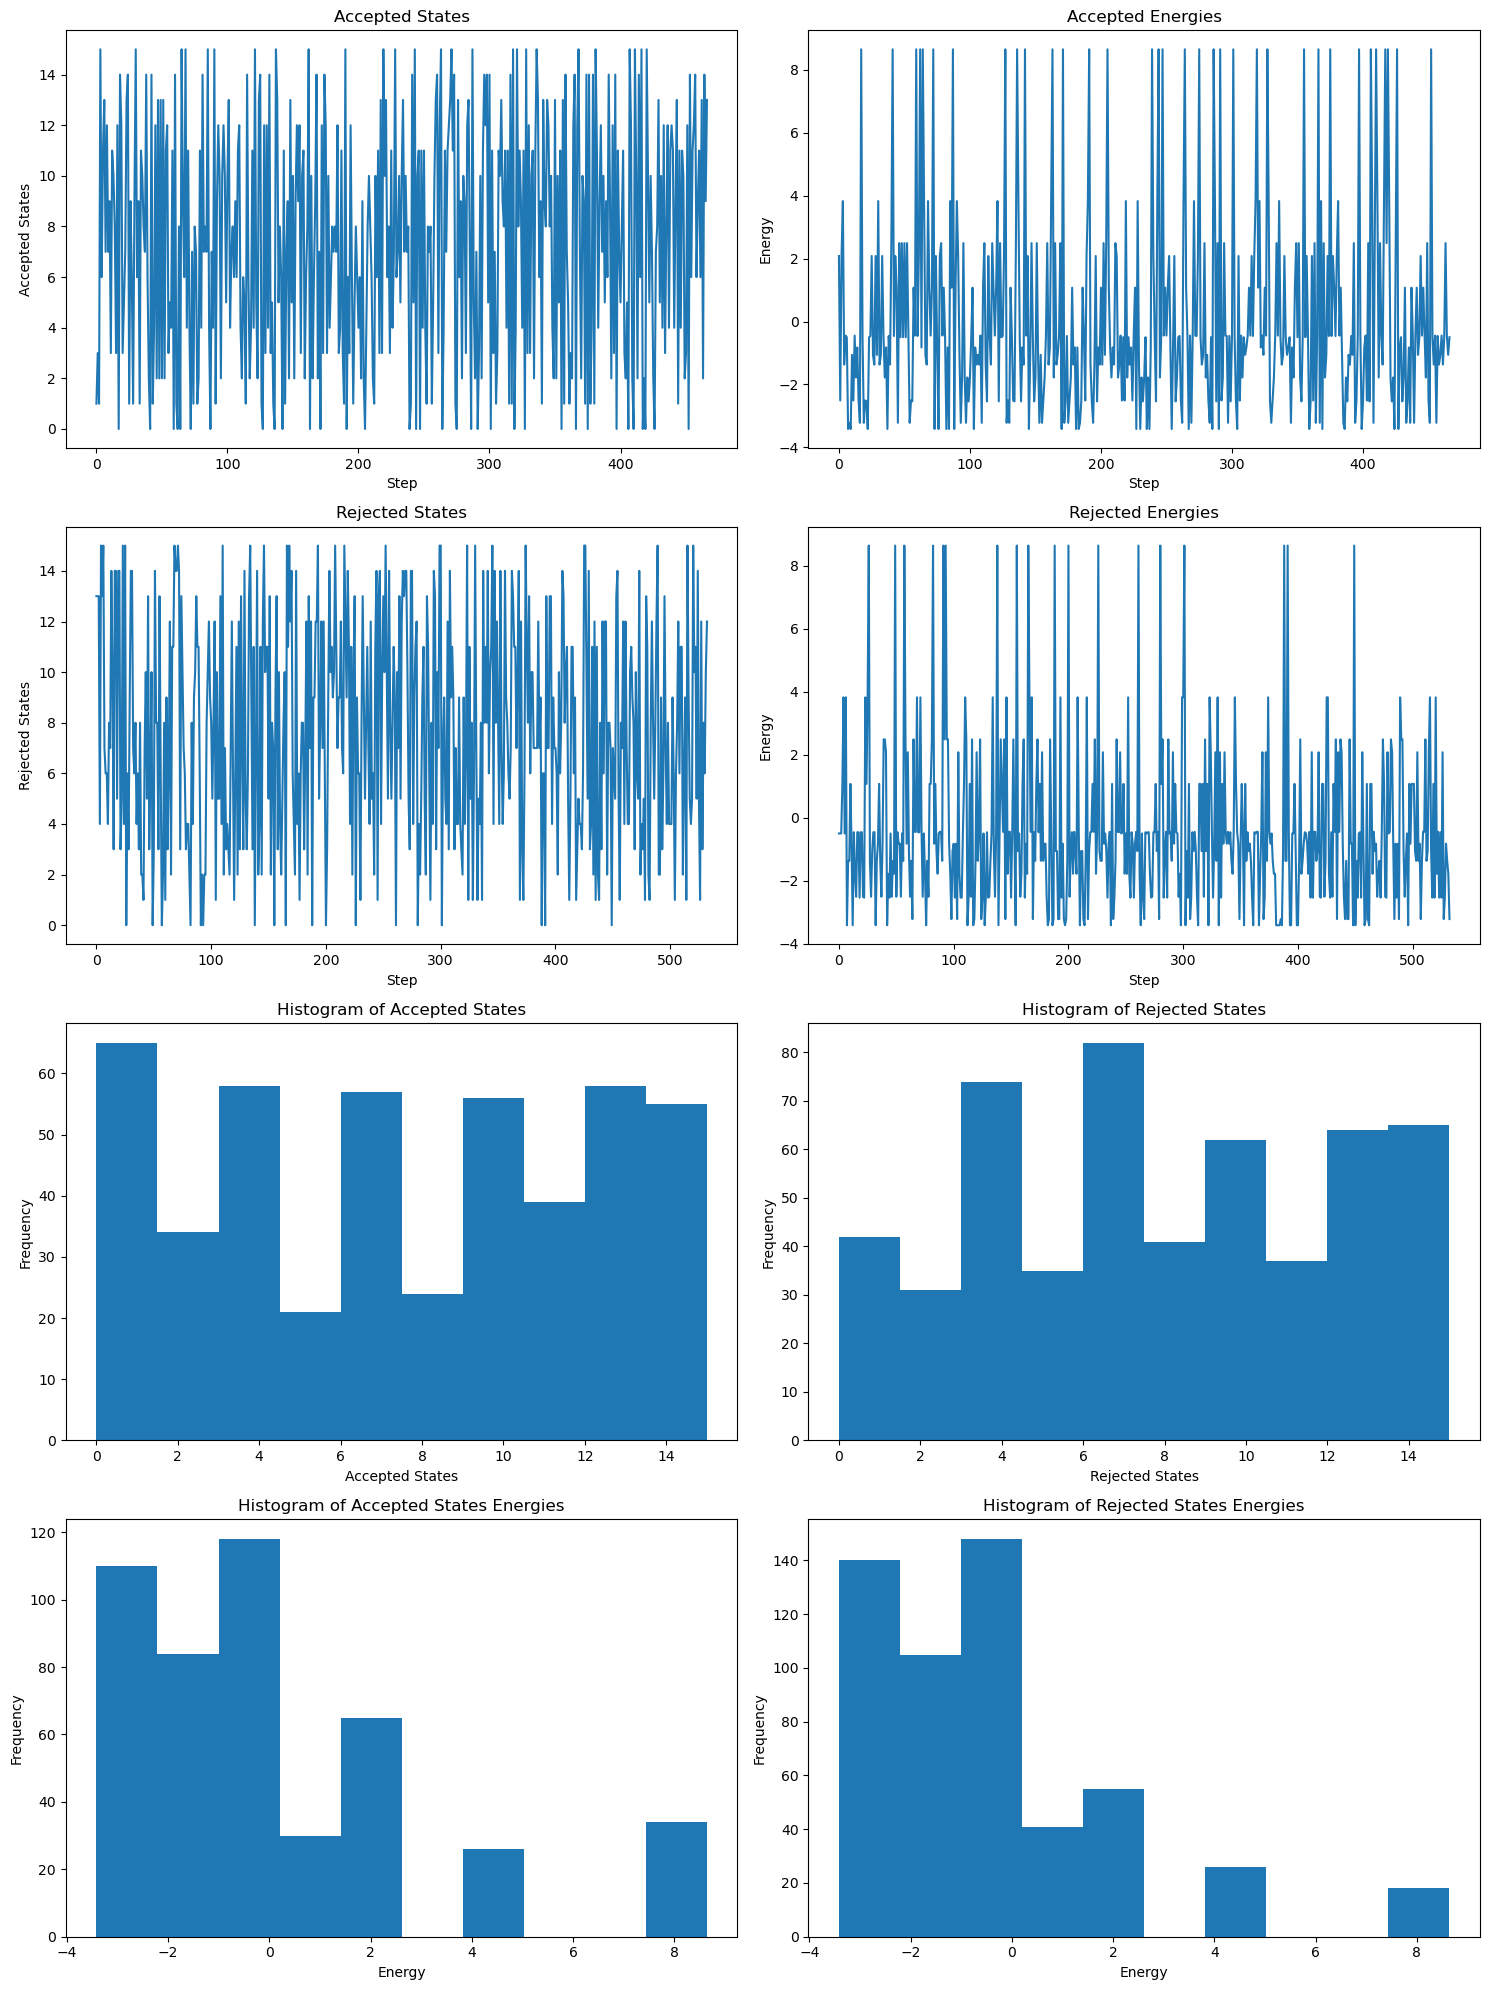

In [208]:
fig, axs = plt.subplots(4, 2, figsize=(15, 20))

# Plot accepted states
axs[0, 0].plot(range(len(accepted_states_int)), accepted_states_int)
axs[0, 0].set(xlabel='Step', ylabel='Accepted States', title='Accepted States')

# Plot accepted energies
axs[0, 1].plot(range(len(accepted_energies)), accepted_energies)
axs[0, 1].set(xlabel='Step', ylabel='Energy', title='Accepted Energies')

# Plot rejected states
axs[1, 0].plot(range(len(rejected_states_int)), rejected_states_int)
axs[1, 0].set(xlabel='Step', ylabel='Rejected States', title='Rejected States')

# Plot rejected energies
axs[1, 1].plot(range(len(rejected_states_int)), rejected_energies)
axs[1, 1].set(xlabel='Step', ylabel='Energy', title='Rejected Energies')

# Plot histogram of accepted states
axs[2, 0].hist(accepted_states_int, bins=10)
axs[2, 0].set(xlabel='Accepted States', ylabel='Frequency', title='Histogram of Accepted States')

# Plot histogram of rejected states
axs[2, 1].hist(rejected_states_int, bins=10)
axs[2, 1].set(xlabel='Rejected States', ylabel='Frequency', title='Histogram of Rejected States')

# Plot histogram of accepted states energies
axs[3, 0].hist(accepted_energies, bins=10)
axs[3, 0].set(xlabel='Energy', ylabel='Frequency', title='Histogram of Accepted States Energies')

# Plot histogram of rejected states energies
axs[3, 1].hist(rejected_energies, bins=10)
axs[3, 1].set(xlabel='Energy', ylabel='Frequency', title='Histogram of Rejected States Energies')

# Adjust the space between plots
plt.tight_layout()
plt.show()

# Classical monte carlo

In [203]:
def flip_single_bit(state):
    """
    This function flips a single bit in the given state at random.
    Args:
        state (numpy.ndarray): The state to be modified.
        indices (range): The range of indices within which the bits will be randomly selected.

    Returns:
        numpy.ndarray: The modified state with the randomly selected bits flipped.
    """
    # Create a copy of the state to avoid modifying the original array
    modified_state = np.copy(state)

    # Randomly select a single index within the specified range
    selected_index = np.random.choice(len(state))

    # Flip the bit at the selected index
    modified_state[selected_index] = 1 - modified_state[selected_index]

    return modified_state


def flip_group_bits(state):
    """
    This function flips a group of bits in the given state at randomly selected indices within the specified range.

    Args:
        state (numpy.ndarray): The state to be modified.
        indices (range): The range of indices within which the bits will be randomly selected.

    Returns:
        numpy.ndarray: The modified state with the randomly selected bits flipped.
    """
    indices = range(len(state//2))

    # Create a copy of the state to avoid modifying the original array
    modified_state = np.copy(state)

    # Randomly select a subset of indices within the specified range
    selected_indices = np.random.choice(indices, size=np.random.randint(1, len(indices)+1), replace=False)

    # Flip the bits at the selected indices
    modified_state[selected_indices] = 1 - modified_state[selected_indices]

    return modified_state


In [204]:
def classical_metropolis_hastings(initial_state, num_steps, proposal_func):
    """
    This function performs the classical Metropolis-Hastings algorithm. It starts from an initial state and performs a given number of steps. At each step, it proposes a new state using the specified proposal function and decides whether to accept or reject it based on the Metropolis-Hastings acceptance probability.

    Args:
        initial_state (numpy.ndarray): The initial state.
        num_steps (int): The number of steps to perform in the Metropolis-Hastings algorithm.
        proposal_func (function): The proposal function that generates a new state given the current state.

    Returns:
        list: A list of accepted states.
        list: A list of rejected states.
        list: A list of energies of the accepted states.
        list: A list of energies of the rejected states.
    """

    # Initialize the current state to the initial state
    current_state = initial_state

    # Initialize lists to store the accepted and rejected states and their energies
    accepted_states = []
    rejected_states = []
    accepted_energies = []
    rejected_energies = []

    # Perform the Metropolis-Hastings algorithm for the specified number of steps
    for step in range(num_steps):
        # Propose a new state using the specified proposal function
        proposed_state = proposal_func(current_state)

        # Compute the energy of the current state
        current_energy = H_energy(current_state, H, num_qubits)

        # Compute the energy of the proposed state
        proposed_energy = H_energy(proposed_state, H, num_qubits)

        # Compute the energy difference between the proposed state and the current state
        energy_difference = compute_scaled_energy_difference(current_state, proposed_state, H, num_qubits, beta)


        # Compute the Metropolis-Hastings acceptance probability
        acceptance_prob = min(1, np.exp(-energy_difference))

        # Decide whether to accept or reject the proposed state
        if np.random.rand() < acceptance_prob:
            # If the proposed state is accepted, update the current state and add the proposed state and its energy to the lists of accepted states and energies
            current_state = proposed_state
            accepted_states.append(proposed_state)
            accepted_energies.append(proposed_energy)
        else:
            # If the proposed state is rejected, add the proposed state and its energy to the lists of rejected states and energies
            rejected_states.append(proposed_state)
            rejected_energies.append(proposed_energy)

    # Return the lists of accepted and rejected states and their energies
    return accepted_states, rejected_states, accepted_energies, rejected_energies


In [205]:
H = get_ising_hamiltonian(J, h, num_qubits)
num_steps = 1000
# proposal_func = flip_single_bit
proposal_func = flip_group_bits
accepted_states, rejected_states, accepted_energies, rejected_energies = classical_metropolis_hastings(initial_state, num_steps, proposal_func)
accepted_states_int = [binary_to_int([int(bit) for bit in state]) for state in accepted_states]
rejected_states_int = [binary_to_int([int(bit) for bit in state]) for state in rejected_states]

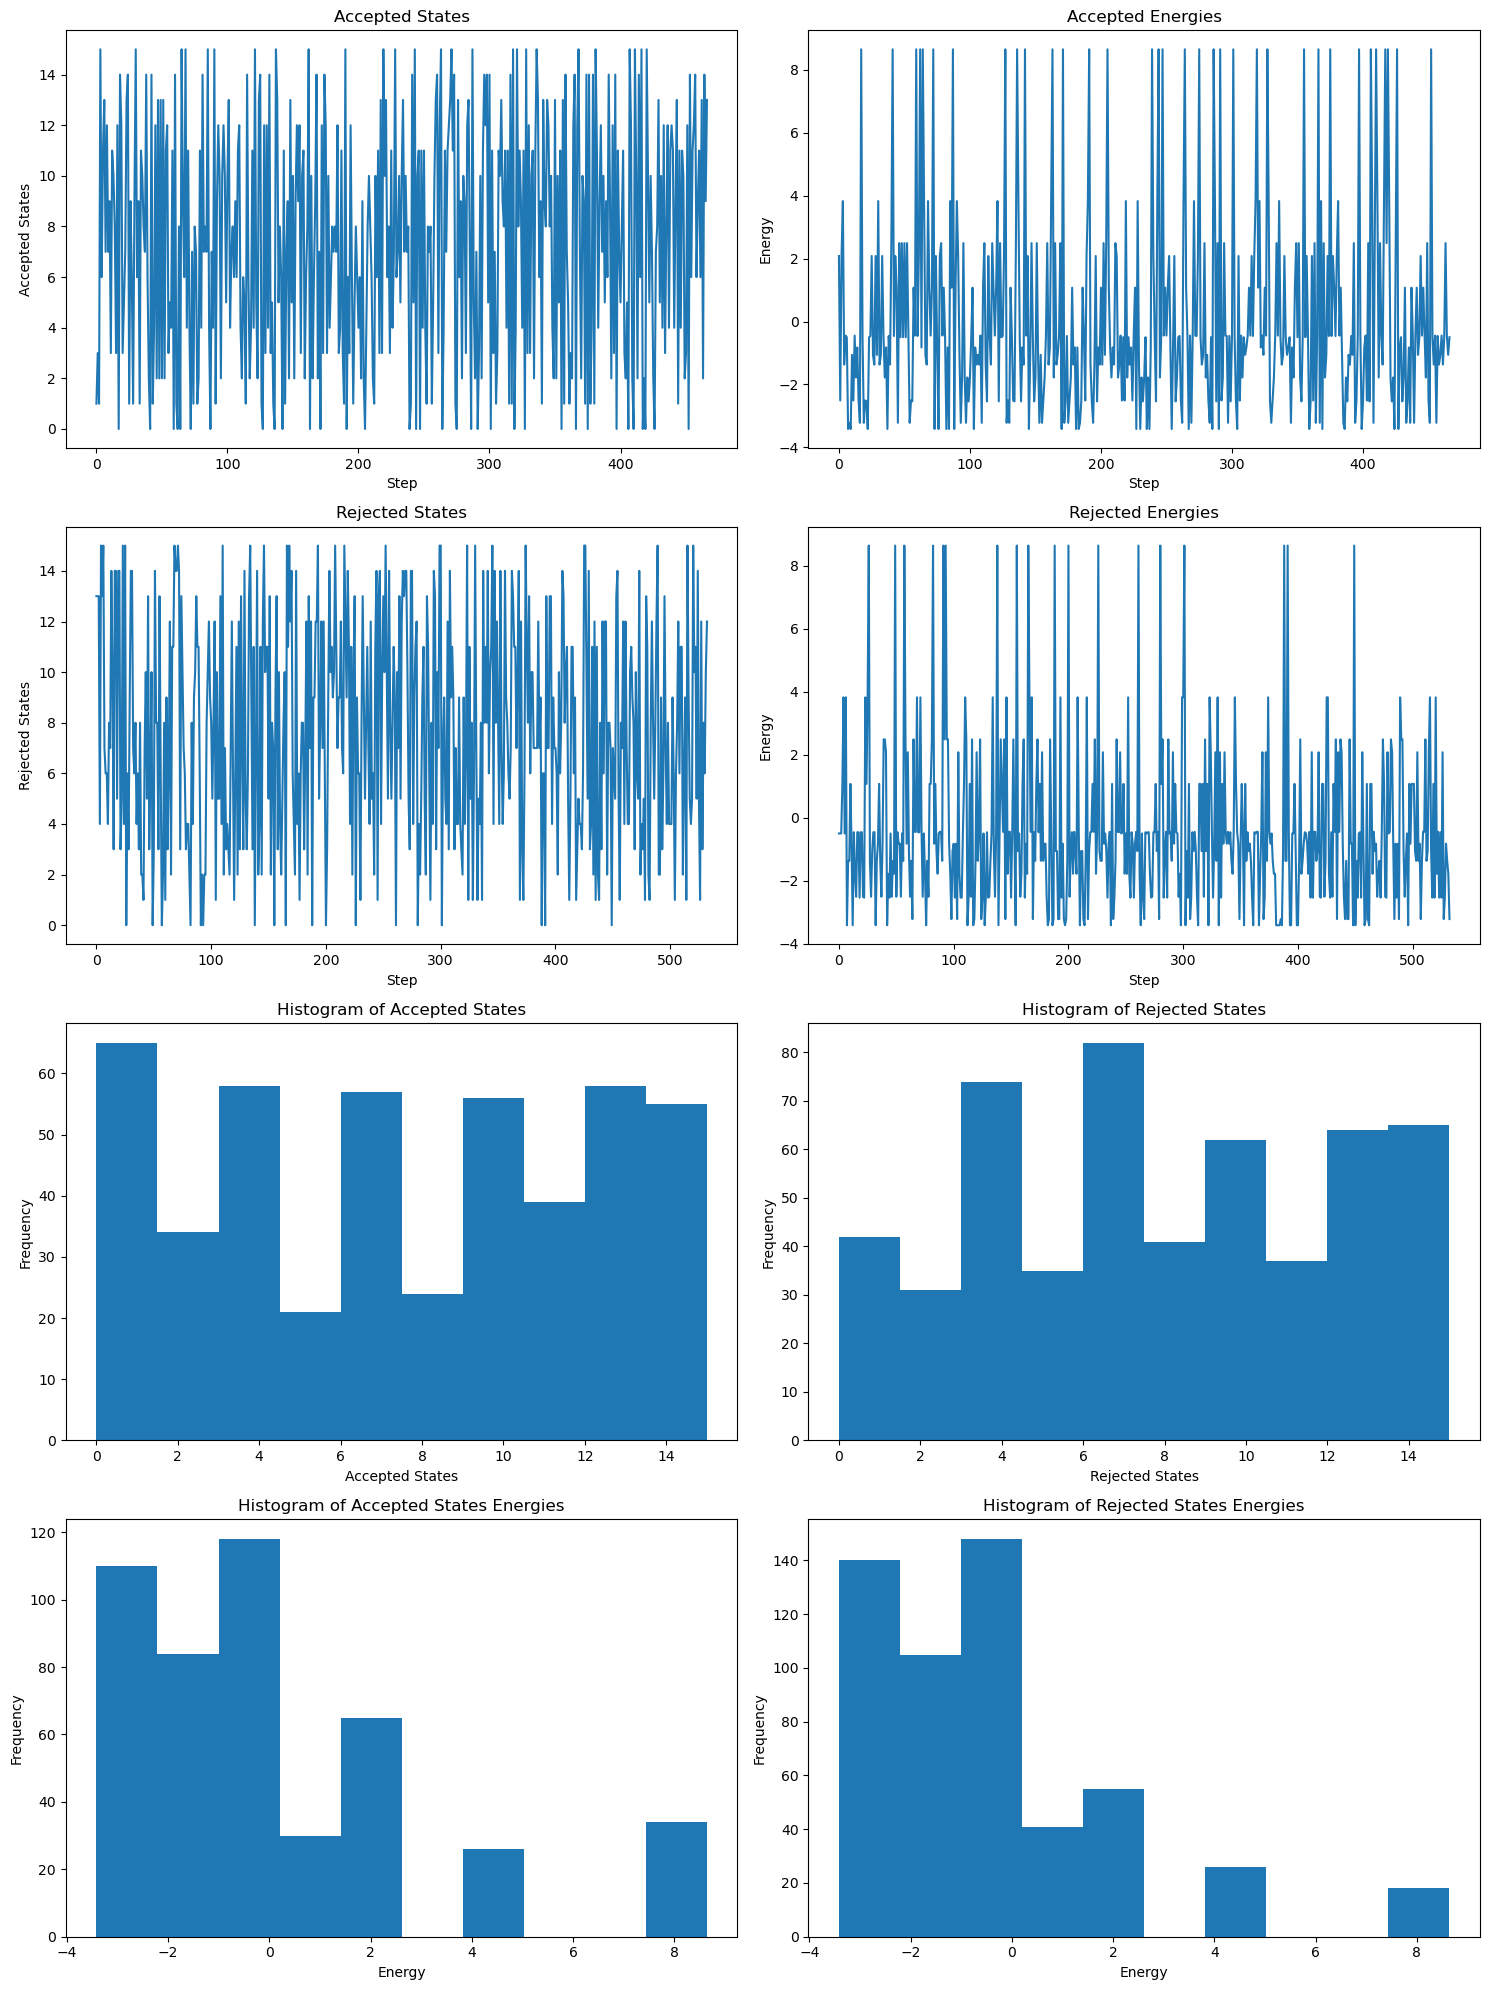

In [207]:
fig, axs = plt.subplots(4, 2, figsize=(15, 20))

# Plot accepted states
axs[0, 0].plot(range(len(accepted_states_int)), accepted_states_int)
axs[0, 0].set(xlabel='Step', ylabel='Accepted States', title='Accepted States')

# Plot accepted energies
axs[0, 1].plot(range(len(accepted_energies)), accepted_energies)
axs[0, 1].set(xlabel='Step', ylabel='Energy', title='Accepted Energies')

# Plot rejected states
axs[1, 0].plot(range(len(rejected_states_int)), rejected_states_int)
axs[1, 0].set(xlabel='Step', ylabel='Rejected States', title='Rejected States')

# Plot rejected energies
axs[1, 1].plot(range(len(rejected_states_int)), rejected_energies)
axs[1, 1].set(xlabel='Step', ylabel='Energy', title='Rejected Energies')

# Plot histogram of accepted states
axs[2, 0].hist(accepted_states_int, bins=10)
axs[2, 0].set(xlabel='Accepted States', ylabel='Frequency', title='Histogram of Accepted States')

# Plot histogram of rejected states
axs[2, 1].hist(rejected_states_int, bins=10)
axs[2, 1].set(xlabel='Rejected States', ylabel='Frequency', title='Histogram of Rejected States')

# Plot histogram of accepted states energies
axs[3, 0].hist(accepted_energies, bins=10)
axs[3, 0].set(xlabel='Energy', ylabel='Frequency', title='Histogram of Accepted States Energies')

# Plot histogram of rejected states energies
axs[3, 1].hist(rejected_energies, bins=10)
axs[3, 1].set(xlabel='Energy', ylabel='Frequency', title='Histogram of Rejected States Energies')

# Adjust the space between plots
plt.tight_layout()
plt.show()

In [209]:
H = get_ising_hamiltonian(J, h, num_qubits)
num_steps = 1000
proposal_func = flip_single_bit
# proposal_func = flip_group_bits
accepted_states, rejected_states, accepted_energies, rejected_energies = classical_metropolis_hastings(initial_state, num_steps, proposal_func)
accepted_states_int = [binary_to_int([int(bit) for bit in state]) for state in accepted_states]
rejected_states_int = [binary_to_int([int(bit) for bit in state]) for state in rejected_states]

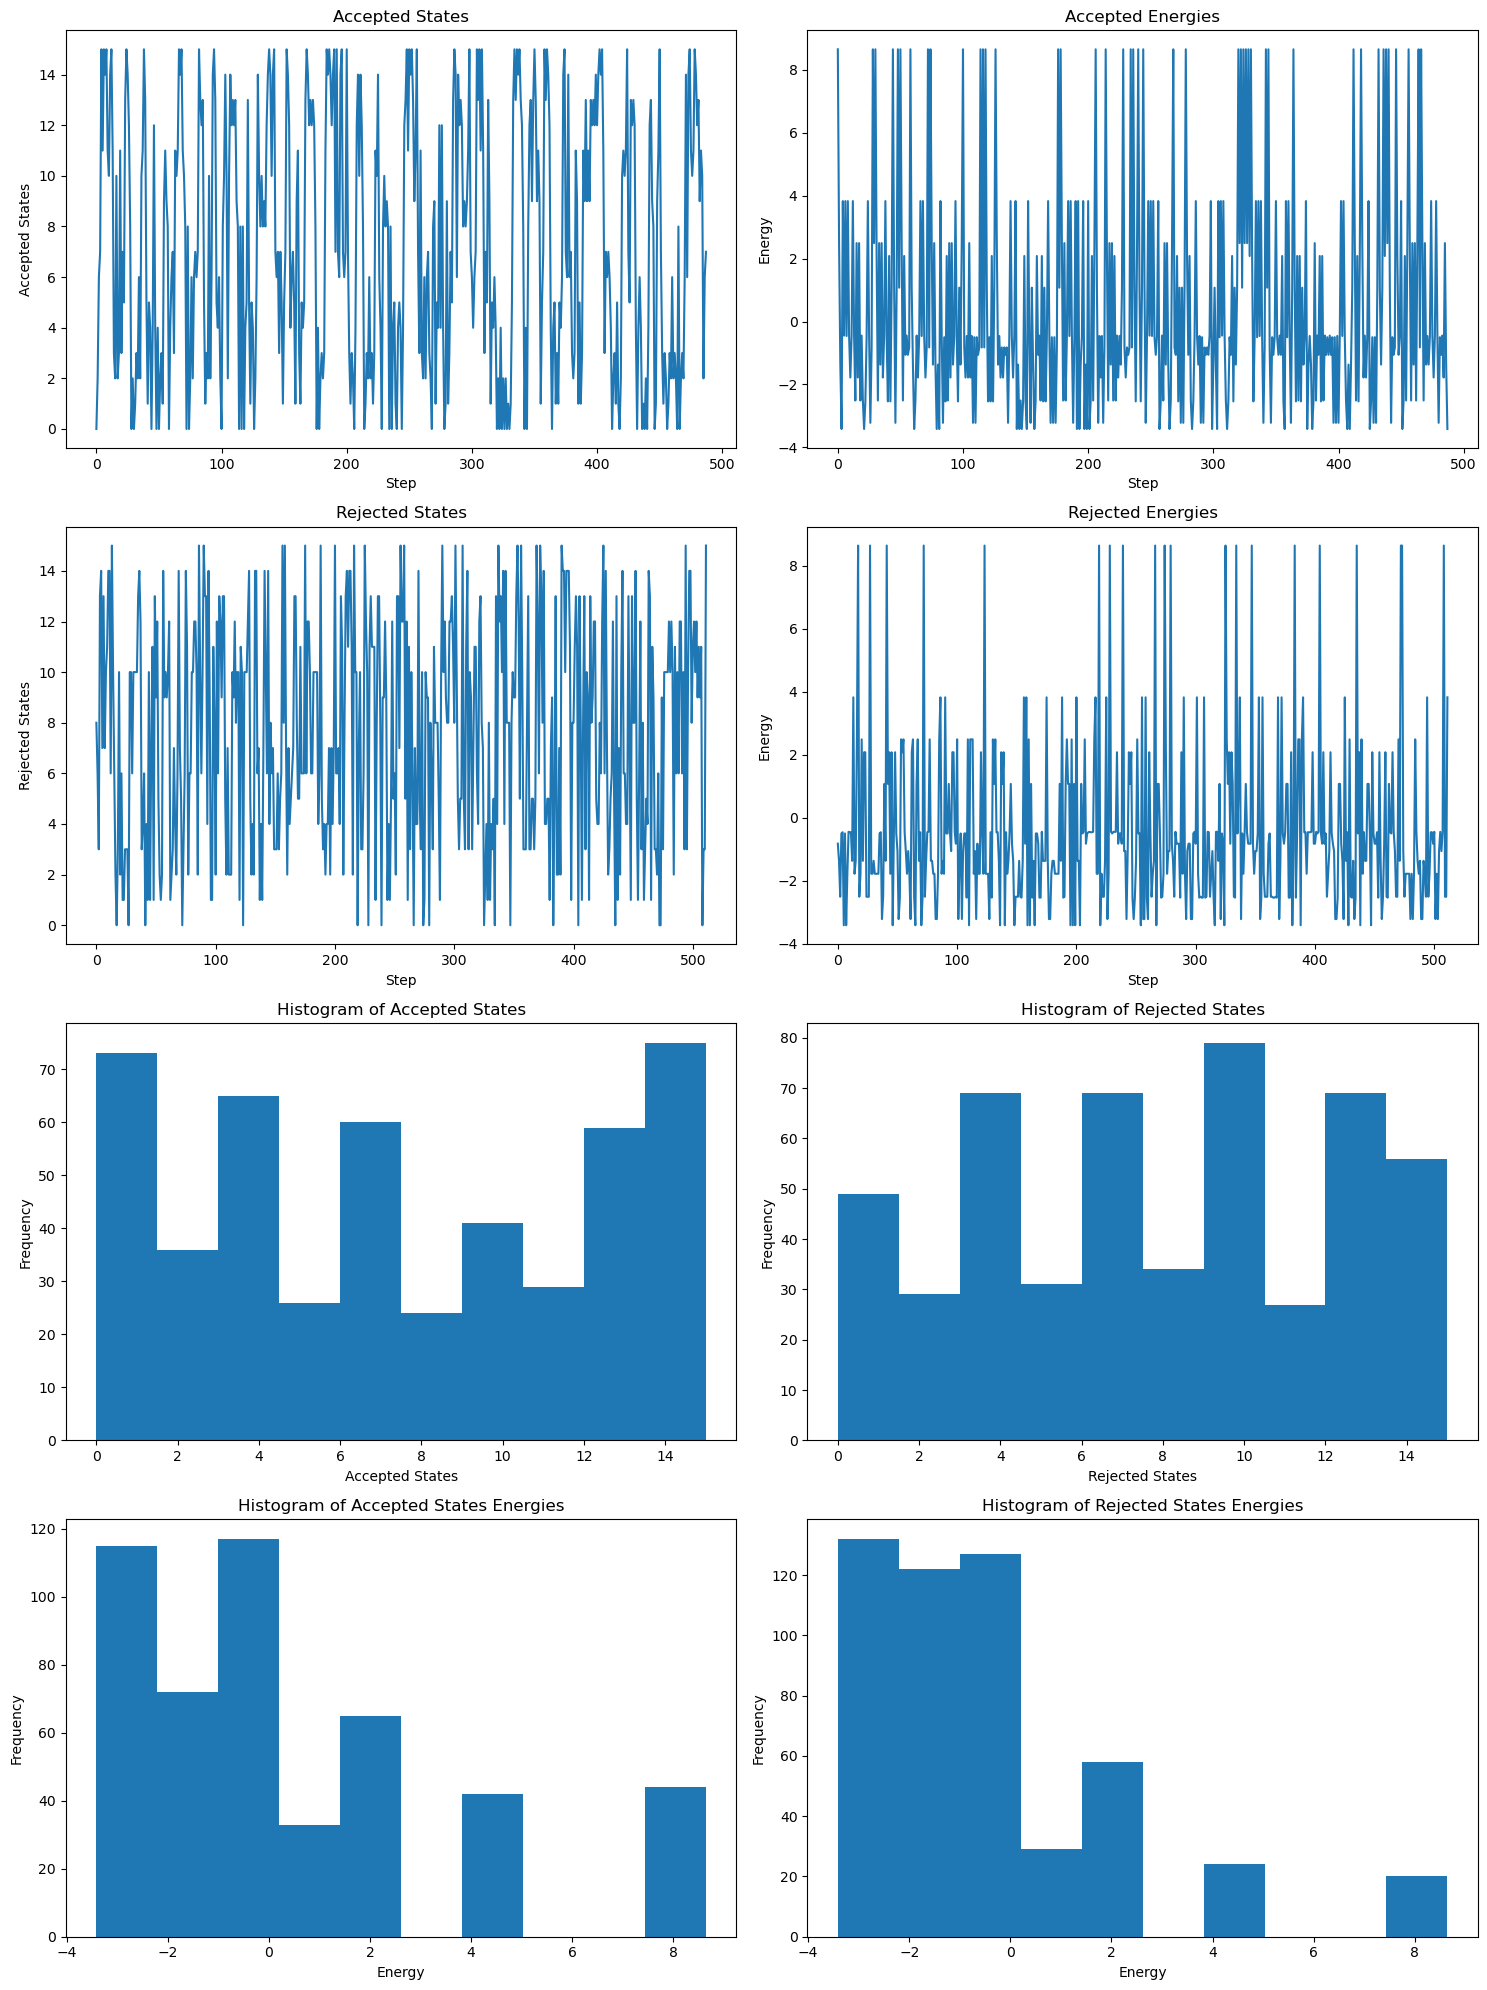

In [210]:
fig, axs = plt.subplots(4, 2, figsize=(15, 20))

# Plot accepted states
axs[0, 0].plot(range(len(accepted_states_int)), accepted_states_int)
axs[0, 0].set(xlabel='Step', ylabel='Accepted States', title='Accepted States')

# Plot accepted energies
axs[0, 1].plot(range(len(accepted_energies)), accepted_energies)
axs[0, 1].set(xlabel='Step', ylabel='Energy', title='Accepted Energies')

# Plot rejected states
axs[1, 0].plot(range(len(rejected_states_int)), rejected_states_int)
axs[1, 0].set(xlabel='Step', ylabel='Rejected States', title='Rejected States')

# Plot rejected energies
axs[1, 1].plot(range(len(rejected_states_int)), rejected_energies)
axs[1, 1].set(xlabel='Step', ylabel='Energy', title='Rejected Energies')

# Plot histogram of accepted states
axs[2, 0].hist(accepted_states_int, bins=10)
axs[2, 0].set(xlabel='Accepted States', ylabel='Frequency', title='Histogram of Accepted States')

# Plot histogram of rejected states
axs[2, 1].hist(rejected_states_int, bins=10)
axs[2, 1].set(xlabel='Rejected States', ylabel='Frequency', title='Histogram of Rejected States')

# Plot histogram of accepted states energies
axs[3, 0].hist(accepted_energies, bins=10)
axs[3, 0].set(xlabel='Energy', ylabel='Frequency', title='Histogram of Accepted States Energies')

# Plot histogram of rejected states energies
axs[3, 1].hist(rejected_energies, bins=10)
axs[3, 1].set(xlabel='Energy', ylabel='Frequency', title='Histogram of Rejected States Energies')

# Adjust the space between plots
plt.tight_layout()
plt.show()